In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from IPython.display import clear_output

# Initialize lists to store losses
train_losses = []
eval_losses = []

def plot_losses(train_losses, val_losses):
    clear_output(wait=True)  # Clears previous plot
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import torch
import torch.nn as nn
from tqdm import tqdm
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '../src')))
from fliqe.datasets import ImageDataset
from fliqe.distortions import *
from models import DistortionBinaryClassifier, IQAEncoder
from torchvision import transforms
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(f"Using device: {device}")

def load_model(model_path, device):
    model = IQAEncoder(feature_dim=128, model_name='resnet50').to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

encoder = load_model('../models/resnet50_128_out.pth', device)
model = DistortionBinaryClassifier(encoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
            
distortions = [Clean(), LensBlur(), MotionBlur(), GaussianNoise(), Overexposure(), Underexposure(), Compression(), Ghosting(), Aliasing()]
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), # 224 or 384
    transforms.ToTensor(),
])

# train_image_folders = [f"../data/video_frames_{i}" for i in range(1, 13) if i != 5]
# image_paths = []
# for folder in train_image_folders:
#     if not os.path.isdir(folder):
#         print(f"Warning: folder {folder} not found, skipping.")
#         continue
#     image_paths.extend(
#         [os.path.join(folder, fname)
#          for fname in os.listdir(folder)
#          if fname.lower().endswith(('.jpg', '.png'))]
#     )
# dataset = ImageDataset(image_paths, distortions=distortions, transform=transform, binary_labels=True)
# train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=16, pin_memory=True, persistent_workers=True, prefetch_factor=8)
# print(f"Train Dataset length: {len(dataset)}")
# eval_image_folders = "../data/video_frames_5" 
# image_paths = [os.path.join(eval_image_folders, fname) for fname in os.listdir(eval_image_folders) if fname.endswith(('.jpg', '.png'))]
# eval_dataset = ImageDataset(image_paths, distortions=distortions, transform=transform, binary_labels=True)
# eval_dataloader = DataLoader(eval_dataset, batch_size=64, shuffle=False, num_workers=16, pin_memory=True, persistent_workers=True, prefetch_factor=8)
# print(f"Eval Dataset length: {len(eval_dataset)}")

# All folders with images
all_folders = [f"../data/video_frames_{i}" for i in range(1, 13)]
# Gather all image paths
all_image_paths = []
for folder in all_folders:
    if not os.path.isdir(folder):
        print(f"Warning: folder {folder} not found, skipping.")
        continue
    all_image_paths.extend(
        [os.path.join(folder, fname)
         for fname in os.listdir(folder)
         if fname.lower().endswith(('.jpg', '.png'))]
    )
print(f"Total images found: {len(all_image_paths)}")

# Shuffle and split
random.shuffle(all_image_paths)
split_ratio = 0.8  # 80% train, 20% eval
split_idx = int(len(all_image_paths) * split_ratio)
train_paths = all_image_paths[:split_idx]
eval_paths = all_image_paths[split_idx:]

# Create datasets
train_dataset = ImageDataset(train_paths, distortions=distortions, transform=transform, binary_labels=True)
eval_dataset = ImageDataset(eval_paths, distortions=distortions, transform=transform, binary_labels=True)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True,
                              num_workers=16, pin_memory=True, persistent_workers=True, prefetch_factor=8)
eval_dataloader = DataLoader(eval_dataset, batch_size=64, shuffle=False,
                             num_workers=16, pin_memory=True, persistent_workers=True, prefetch_factor=8)

print(f"Train Dataset length: {len(train_dataset)}")
print(f"Eval Dataset length: {len(eval_dataset)}")

epochs = 100                        # maximum number of training epochs
consecutive_training_epochs = 1     # number of epochs between evaluations
patience = 10                       # number of epochs to wait before stopping
no_improve_count = 0                # counter for consecutive non-improving epochs
before = {k: v.detach().clone() for k, v in model.iqa_encoder.state_dict().items()}
best_loss = float('inf')
for epoch in range(epochs):
    model.train()

    train_loss = 0.0
    for imgs, labels in tqdm(train_dataloader, desc=f"Binary Epoch {epoch+1}", leave=False):
        imgs = imgs.to(device)
        binary_labels = torch.tensor([0.0 if l == 'Clean' else 1.0 for l in labels], dtype=torch.float32, device=device).unsqueeze(1)  # shape: [B, 1]

        logits = model(imgs)
        loss = loss_fn(logits, binary_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_losses.append(train_loss / len(train_dataloader))

    print(f"~~~~~~~~~~~ Epoch {epoch+1} ~~~~~~~~~~~")
    after = model.iqa_encoder.state_dict()
    for k in before:
        if not torch.equal(before[k], after[k]):
            print("⚠️ Encoder Changed")
            break
    print(f"Training Loss: {train_loss / len(train_dataloader):.4f}")

    # Validation
    if ((epoch + 1) % consecutive_training_epochs == 0) or (epoch == 0):
        accuracy = 0.0
        eval_loss = 0.0
        model.eval()

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for imgs, labels in tqdm(eval_dataloader, desc=f"Eval Epoch {epoch+1}", leave=False):
                imgs = imgs.to(device)
                binary_labels = torch.tensor(
                    [0.0 if l == 'Clean' else 1.0 for l in labels],
                    dtype=torch.float32, device=device
                ).unsqueeze(1)

                logits = model(imgs)
                preds = (torch.sigmoid(logits) > 0.5).float()

                # For metrics
                all_preds.extend(preds.cpu().numpy().flatten())
                all_labels.extend(binary_labels.cpu().numpy().flatten())

                # Loss and accuracy (batch level)
                eval_loss += loss_fn(logits, binary_labels).item()
                accuracy += (preds == binary_labels).float().mean().item()

        # Average loss and accuracy
        eval_loss /= len(eval_dataloader)
        accuracy /= len(eval_dataloader)

        # Convert to numpy arrays for sklearn metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        # Compute precision, recall, F1
        precision = precision_score(all_labels, all_preds, zero_division=0)
        recall = recall_score(all_labels, all_preds, zero_division=0)
        f1 = f1_score(all_labels, all_preds, zero_division=0)

        eval_losses.append(eval_loss)

        print(f"Eval Loss: {eval_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

        # --- Early stopping logic ---
        if eval_loss < best_loss:
            best_loss = eval_loss
            no_improve_count = 0
            torch.save(model.state_dict(), f'../models/encoder_with_binary_head.pth')
            print(f"✅ Saved Best Model with Eval Loss: {best_loss:.4f}")
        else:
            optimizer.param_groups[0]['lr'] *= 0.95
            no_improve_count += 1
            print(f"⚠️ No improvement for {no_improve_count}/{patience} epochs.")
            if no_improve_count >= patience:
                print(f"🛑 Early stopping triggered at epoch {epoch + 1}. Best eval loss: {best_loss:.4f}")
                break
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        


2.8.0+cu129
True
12.9
91002
Using device: cuda
Total images found: 80670
Train Dataset length: 64536
Eval Dataset length: 16134


~~~~~~~~~~~ Epoch 1 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.3690


Eval Loss: 0.3070
Accuracy: 0.8724, Precision: 0.9056, Recall: 0.7970, F1-score: 0.8478
✅ Saved Best Model with Eval Loss: 0.3070
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 2 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.3221


Eval Loss: 0.2791
Accuracy: 0.8845, Precision: 0.9101, Recall: 0.8218, F1-score: 0.8637
✅ Saved Best Model with Eval Loss: 0.2791
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 3 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.3088


Eval Loss: 0.2707
Accuracy: 0.8905, Precision: 0.8978, Recall: 0.8520, F1-score: 0.8743
✅ Saved Best Model with Eval Loss: 0.2707
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 4 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2953


Eval Loss: 0.2517
Accuracy: 0.9004, Precision: 0.9139, Recall: 0.8560, F1-score: 0.8840
✅ Saved Best Model with Eval Loss: 0.2517
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 5 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2898


Eval Loss: 0.2526
Accuracy: 0.8991, Precision: 0.9266, Recall: 0.8376, F1-score: 0.8799
⚠️ No improvement for 1/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 6 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2793


Eval Loss: 0.2508
Accuracy: 0.9012, Precision: 0.9297, Recall: 0.8425, F1-score: 0.8839
✅ Saved Best Model with Eval Loss: 0.2508
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 7 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2832


Eval Loss: 0.2466
Accuracy: 0.8998, Precision: 0.9126, Recall: 0.8565, F1-score: 0.8836
✅ Saved Best Model with Eval Loss: 0.2466
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 8 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2724


Eval Loss: 0.2304
Accuracy: 0.9113, Precision: 0.9219, Recall: 0.8728, F1-score: 0.8967
✅ Saved Best Model with Eval Loss: 0.2304
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 9 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2759


Eval Loss: 0.2266
Accuracy: 0.9109, Precision: 0.9282, Recall: 0.8652, F1-score: 0.8956
✅ Saved Best Model with Eval Loss: 0.2266
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 10 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2685


Eval Loss: 0.2254
Accuracy: 0.9123, Precision: 0.9486, Recall: 0.8471, F1-score: 0.8949
✅ Saved Best Model with Eval Loss: 0.2254
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 11 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2634


Eval Loss: 0.2188
Accuracy: 0.9158, Precision: 0.9394, Recall: 0.8657, F1-score: 0.9011
✅ Saved Best Model with Eval Loss: 0.2188
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 12 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2666


Eval Loss: 0.2218
Accuracy: 0.9132, Precision: 0.9311, Recall: 0.8665, F1-score: 0.8977
⚠️ No improvement for 1/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 13 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2625


Eval Loss: 0.2200
Accuracy: 0.9141, Precision: 0.9413, Recall: 0.8560, F1-score: 0.8966
⚠️ No improvement for 2/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 14 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2599


Eval Loss: 0.2069
Accuracy: 0.9202, Precision: 0.9515, Recall: 0.8614, F1-score: 0.9042
✅ Saved Best Model with Eval Loss: 0.2069
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 15 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2551


Eval Loss: 0.2201
Accuracy: 0.9113, Precision: 0.9247, Recall: 0.8705, F1-score: 0.8968
⚠️ No improvement for 1/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 16 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2552


Eval Loss: 0.2142
Accuracy: 0.9151, Precision: 0.9469, Recall: 0.8603, F1-score: 0.9015
⚠️ No improvement for 2/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 17 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2521


Eval Loss: 0.2092
Accuracy: 0.9193, Precision: 0.9315, Recall: 0.8828, F1-score: 0.9065
⚠️ No improvement for 3/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 18 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2466


Eval Loss: 0.2139
Accuracy: 0.9150, Precision: 0.9397, Recall: 0.8635, F1-score: 0.9000
⚠️ No improvement for 4/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 19 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2449


Eval Loss: 0.2114
Accuracy: 0.9174, Precision: 0.9524, Recall: 0.8586, F1-score: 0.9031
⚠️ No improvement for 5/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 20 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2482


Eval Loss: 0.2050
Accuracy: 0.9209, Precision: 0.9395, Recall: 0.8755, F1-score: 0.9064
✅ Saved Best Model with Eval Loss: 0.2050
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 21 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2433


Eval Loss: 0.2015
Accuracy: 0.9222, Precision: 0.9393, Recall: 0.8793, F1-score: 0.9083
✅ Saved Best Model with Eval Loss: 0.2015
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 22 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2447


Eval Loss: 0.2176
Accuracy: 0.9150, Precision: 0.9096, Recall: 0.8983, F1-score: 0.9039
⚠️ No improvement for 1/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 23 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2394


Eval Loss: 0.2041
Accuracy: 0.9208, Precision: 0.9463, Recall: 0.8710, F1-score: 0.9071
⚠️ No improvement for 2/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 24 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2400


Eval Loss: 0.1956
Accuracy: 0.9243, Precision: 0.9503, Recall: 0.8765, F1-score: 0.9119
✅ Saved Best Model with Eval Loss: 0.1956
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 25 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2417


Eval Loss: 0.1926
Accuracy: 0.9268, Precision: 0.9590, Recall: 0.8714, F1-score: 0.9131
✅ Saved Best Model with Eval Loss: 0.1926
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 26 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2388


Eval Loss: 0.2017
Accuracy: 0.9233, Precision: 0.9564, Recall: 0.8687, F1-score: 0.9105
⚠️ No improvement for 1/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 27 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2395


Eval Loss: 0.2023
Accuracy: 0.9220, Precision: 0.9533, Recall: 0.8654, F1-score: 0.9072
⚠️ No improvement for 2/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 28 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2384


Eval Loss: 0.1973
Accuracy: 0.9233, Precision: 0.9518, Recall: 0.8719, F1-score: 0.9101
⚠️ No improvement for 3/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 29 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2317


Eval Loss: 0.1839
Accuracy: 0.9286, Precision: 0.9500, Recall: 0.8870, F1-score: 0.9174
✅ Saved Best Model with Eval Loss: 0.1839
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 30 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2326


Eval Loss: 0.1937
Accuracy: 0.9271, Precision: 0.9450, Recall: 0.8877, F1-score: 0.9154
⚠️ No improvement for 1/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 31 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2353


Eval Loss: 0.1833
Accuracy: 0.9275, Precision: 0.9423, Recall: 0.8917, F1-score: 0.9163
✅ Saved Best Model with Eval Loss: 0.1833
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 32 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2312


Eval Loss: 0.1944
Accuracy: 0.9268, Precision: 0.9417, Recall: 0.8904, F1-score: 0.9153
⚠️ No improvement for 1/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 33 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2324


Eval Loss: 0.1927
Accuracy: 0.9239, Precision: 0.9421, Recall: 0.8832, F1-score: 0.9117
⚠️ No improvement for 2/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 34 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2308


Eval Loss: 0.1915
Accuracy: 0.9263, Precision: 0.9484, Recall: 0.8832, F1-score: 0.9147
⚠️ No improvement for 3/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 35 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2319


Eval Loss: 0.1905
Accuracy: 0.9255, Precision: 0.9497, Recall: 0.8815, F1-score: 0.9143
⚠️ No improvement for 4/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 36 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2289


Eval Loss: 0.1851
Accuracy: 0.9295, Precision: 0.9439, Recall: 0.8939, F1-score: 0.9182
⚠️ No improvement for 5/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 37 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2288


Eval Loss: 0.1908
Accuracy: 0.9276, Precision: 0.9474, Recall: 0.8857, F1-score: 0.9155
⚠️ No improvement for 6/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 38 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2271


Eval Loss: 0.1857
Accuracy: 0.9279, Precision: 0.9532, Recall: 0.8820, F1-score: 0.9162
⚠️ No improvement for 7/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 39 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2259


Eval Loss: 0.1909
Accuracy: 0.9257, Precision: 0.9400, Recall: 0.8909, F1-score: 0.9148
⚠️ No improvement for 8/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 40 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2289


Eval Loss: 0.1933
Accuracy: 0.9245, Precision: 0.9418, Recall: 0.8827, F1-score: 0.9113
⚠️ No improvement for 9/10 epochs.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~ Epoch 41 ~~~~~~~~~~~
⚠️ Encoder Changed
Training Loss: 0.2262


Eval Loss: 0.1800
Accuracy: 0.9317, Precision: 0.9418, Recall: 0.9007, F1-score: 0.9208
✅ Saved Best Model with Eval Loss: 0.1800
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


KeyboardInterrupt: 

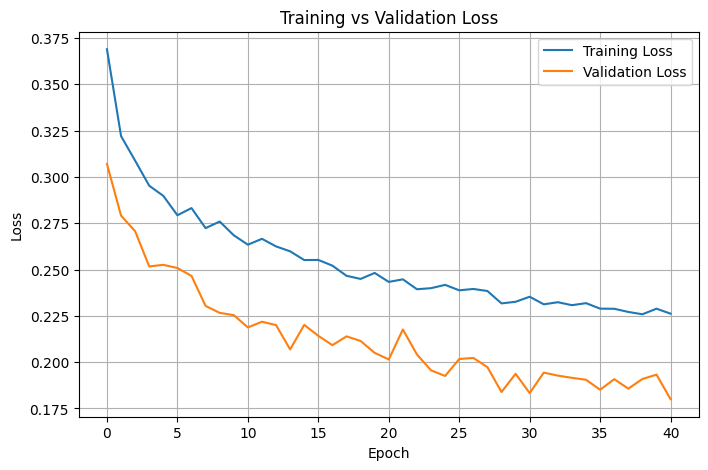

In [3]:
plot_losses(train_losses, eval_losses)

In [4]:
torch.save(model.state_dict(), f'../models/encoder_with_binary_head.pth')